# Load Necessary Library

In [1]:
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
from torchvision import models
from torchvision.datasets import CocoDetection

from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import math
import os
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download MS Coco Dataset

In [2]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-05-04 06:58:52--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.110.156
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.110.156|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  16.8MB/s    in 18m 37s 

2022-05-04 07:17:30 (16.5 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-05-04 07:17:30--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.106.28
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.106.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  16.6MB/s    in 48s     

2022-05-04 07:18:19 (16.1 MB/s) - 

# Unzip Coco Dataset

In [3]:
!unzip /content/train2017.zip
!unzip /content/val2017.zip
!unzip /content/annotations_trainval2017.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 ext

# Define Custum Coco Dataset 

In [4]:
class_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [5]:
class CustomCocoDetection(CocoDetection):
    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = np.array(img)
        height, width = img.shape[:2]

        labels = []
        for obj in target:
            class_id = obj['category_id']
            xmin, ymin, w, h = obj['bbox']
            labels.append([xmin / width, ymin / height, w / width, h / height, class_id])

        if len(labels) == 0:
            labels.append([0.0, 0.0, 1e-8, 1e-8, 0.0])

        if self.transform is not None:
            img = self.transform(img)

        if torch.rand(1) > 0.5:
            img = torchvision.transforms.functional.hflip(img)
            for label in labels:
                xmax = label[0] + label[2]
                if xmax == 1e-8:
                    label[0] = 0
                else:
                    label[0] = 1 - xmax

        return img, torch.tensor(labels)

# Load Train Dataset & Val Dataset
# Visualization Data

In [6]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((800, 1024)), transforms.ToTensor()])
train_dataset = CustomCocoDetection('/content/train2017', '/content/annotations/instances_train2017.json', transform=transform)
val_dataset = CustomCocoDetection('/content/val2017', '/content/annotations/instances_val2017.json', transform=transform)

loading annotations into memory...
Done (t=15.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


torch.Size([3, 800, 1024])
tensor([0.0000e+00, 0.0000e+00, 1.0000e-08, 1.0000e-08, 0.0000e+00])


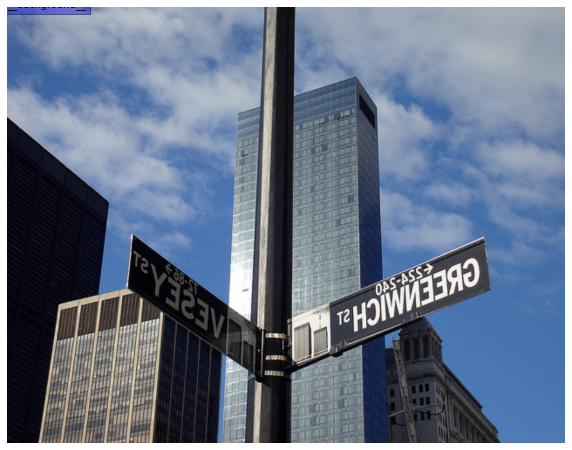

In [7]:
img, labels = train_dataset[42]
print(img.shape)
def visualization(img, labels):
    img = torch.permute(img, (1, 2, 0))
    height, width, channel = img.shape
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    ax = plt.gca()
    for label in labels:
        print(label)
        x, y, w, h = label[:4]
        patch = plt.Rectangle((x * width, y * height), w * width, h * height, fill=False, edgecolor=[0, 0, 1])
        ax.add_patch(patch)
        ax.text(
            x * width,
            y * height,
            class_names[int(label[4])],
            bbox={"facecolor": [0, 0, 1], "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()

visualization(img, labels)

# Define AnchorBox Class 
- (It is a class that brings 9 boxes of pixels for every 5 areas.)

In [8]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = torch.sqrt(torch.tensor(area / ratio))
                anchor_width = area / anchor_height
                dims = torch.reshape(
                    torch.stack([anchor_width, anchor_height], -1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(torch.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = torch.arange(feature_height, dtype=torch.float32) + 0.5
        ry = torch.arange(feature_width, dtype=torch.float32) + 0.5
        center_x, center_y = torch.meshgrid(rx, ry, indexing='ij')
        centers = torch.stack([center_x, center_y], -1)
        centers = torch.unsqueeze(centers, -2)
        centers = torch.tile(centers, (1, 1, self._num_anchors, 1))
        dims = torch.tile(self._anchor_dims[level - 3], (int(feature_height), int(feature_width), 1, 1))
        anchors = torch.cat([centers, dims], -1)
        
        return torch.reshape(anchors, (int(feature_height) * int(feature_width) * self._num_anchors, 4))
    
    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                torch.ceil(torch.tensor(image_height / 2 ** i)),
                torch.ceil(torch.tensor(image_width / 2 ** i)),
                i,
            )
            for i in range(3, 8)
        ]
        return torch.cat(anchors, 0)

# Define utils functions
- (convert_to_corners - convert [x, y, w, h]  ->  [xmin, ymin, xmax, ymax])
- (compute_iou - Calculate the iou of both gt_boxes and anchor_boxes)

In [9]:
def convert_to_corners(boxes):
    return torch.cat([boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1)

In [10]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    left_up = torch.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    right_down = torch.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = torch.maximum(torch.tensor(0.0), right_down - left_up)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = torch.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, torch.tensor(1e-8))

    return torch.clamp(intersection_area / union_area, 0.0, 1.0)

# Define LabelEncoder Class
 - It is a class that produces the final label.

In [11]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = torch.tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=torch.float32
        )

    def extract_matched_boxes(self, gt_boxes, matched_gt_idx):
        matched_gt_boxes = []
        for idx in matched_gt_idx:
            matched_gt_boxes.append(gt_boxes[idx])
        return torch.stack(matched_gt_boxes)

    def extract_matched_cls_ids(self, cls_ids, matched_gt_idx):
        matched_gt_cls_ids = []
        for idx in matched_gt_idx:
            matched_gt_cls_ids.append(cls_ids[idx])
        return torch.stack(matched_gt_cls_ids)

    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        _, max_iou = torch.max(iou_matrix, 1)
        matched_gt_idx = torch.argmax(iou_matrix, 1)
        positive_mask = torch.ge(max_iou, match_iou)
        negative_mask = torch.less(max_iou, ignore_iou)
        ignore_mask = torch.logical_not(torch.logical_or(positive_mask, negative_mask))
        return (matched_gt_idx, positive_mask.type(torch.FloatTensor), ignore_mask.type(torch.FloatTensor))

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = torch.cat([
            (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                torch.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])], axis=-1)
        box_target = box_target / self._box_variance
        return box_target
    
    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[0], image_shape[1])
        cls_ids = cls_ids.type(torch.FloatTensor)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(anchor_boxes, gt_boxes)
        matched_gt_idx = torch.unsqueeze(matched_gt_idx, -1)

        matched_gt_boxes = self.extract_matched_boxes(gt_boxes, matched_gt_idx)
        matched_gt_boxes = torch.squeeze(matched_gt_boxes, axis=1)
        
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = self.extract_matched_cls_ids(cls_ids, matched_gt_idx)
        matched_gt_cls_ids = torch.squeeze(matched_gt_cls_ids, 1)

        cls_target = torch.where(torch.ne(positive_mask, 1.0), -1.0, matched_gt_cls_ids.type(torch.DoubleTensor))
        cls_target = torch.where(torch.tensor(torch.equal(ignore_mask, torch.tensor(1.0))), -2.0, cls_target)
        cls_target = torch.unsqueeze(cls_target, -1)
        label = torch.cat([box_target, cls_target], -1)
        return label

    def encode_batch(self, batch):
        imgs = [x[0] for x in batch]
        labels = [x[1] for x in batch]
        batch_images = torch.stack(imgs)

        labels = []
        for i in range(len(batch)):
            image_shape = batch_images.shape[-2:]
            batch_size = batch_images.shape[0]
            gt_boxes = batch[i][1][..., :4]
            cls_ids = batch[i][1][..., 4]
            label = self._encode_sample(image_shape, gt_boxes, cls_ids)
            labels.append(label)
        labels = torch.stack(labels)
        return batch_images, labels

# Load Train & Validation DataLoader

In [15]:
label_encoder = LabelEncoder()
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=label_encoder.encode_batch)
val_loader = DataLoader(val_dataset, batch_size=2, collate_fn=label_encoder.encode_batch)

# Define RetinaNet
- Backbone : ResNet50

In [14]:
class BasicBlock(nn.Module):
    mul = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential()

        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.block(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BottleNeck(nn.Module):
    mul = 4
    def __init__(self, in_channels, out_channels, stride):
        super(BottleNeck, self).__init__()
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * self.mul, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * self.mul)
        )

        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels * self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.mul)
        )
            
    def forward(self, x):
        out = self.bottleneck(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.maxpool1 = nn.MaxPool2d(3, 2)
        
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.mul
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool1(out)
        out = self.layer1(out)
        conv3_out = self.layer2(out)
        conv4_out = self.layer3(conv3_out)
        conv5_out = self.layer4(conv4_out)
        return conv3_out, conv4_out, conv5_out

In [16]:
def get_backbone():
    return ResNet(BottleNeck, [3, 4, 6, 3])

In [17]:
class FeaturePyramid(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = get_backbone()
        
        self.conv_c3_1x1 = nn.Conv2d(512, 256, 1, 1)
        self.conv_c4_1x1 = nn.Conv2d(1024, 256, 1, 1)
        self.conv_c5_1x1 = nn.Conv2d(2048, 256, 1, 1)
        self.conv_c3_3x3 = nn.Conv2d(256,256, 3, 1, 1)
        self.conv_c4_3x3 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv_c5_3x3 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv_c6_3x3 = nn.Conv2d(2048, 256, 3, 2, 1)
        self.conv_c7_3x3 = nn.Conv2d(256, 256, 3, 2, 1)
        self.upsample_2x = nn.Upsample(scale_factor=2)
        
    def forward(self, images):
        c3_output, c4_output, c5_output = self.backbone(images)
        
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(F.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [18]:
def build_head(output_filters, bias_init):
    sequential = []
    for _ in range(4):
        sequential.append(nn.Conv2d(256, 256, 3, 1, 1))
        sequential.append(nn.ReLU())
    head = nn.Sequential(*sequential)
    for m in head.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean=0, std=0.01)
    
    conv = nn.Conv2d(256, output_filters, 3, 1, 1)
    nn.init.normal_(conv.weight, mean=0, std=0.01)
    if bias_init is not None:
        nn.init.constant_(conv.bias, bias_init)
    
    head.add_module('8', conv)
    return head

In [19]:
class RetinaNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.fpn = FeaturePyramid()
        self.n_classes = n_classes

        prior_probability = -np.log((1 - 0.01) / 0.01)
        self.cls_head = build_head(9 * n_classes, prior_probability)
        self.box_head = build_head(9 * 4, None)

    def forward(self, image):
        features = self.fpn(image)
        batch_size = image.shape[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(torch.reshape(self.box_head(feature), [batch_size, -1, 4]))
            cls_outputs.append(
                torch.reshape(self.cls_head(feature), [batch_size, -1, self.n_classes])
            )
        cls_outputs = torch.cat(cls_outputs, axis=1)
        box_outputs = torch.cat(box_outputs, axis=1)
        return torch.cat([box_outputs, cls_outputs], axis=-1)

# Define RetinaNet Loss
- Smooth L1 Loss(Box Loss)
- Focal Loss(Classification Loss)

In [20]:
class RetinaNetBoxLoss(nn.Module):
    def __init__(self, delta):
        super().__init__()
        self._delta = delta

    def forward(self, y_pred, y_true):
        difference = y_true - y_pred
        absolute_difference = torch.abs(difference)
        squared_difference = difference ** 2
        loss = torch.where(
            torch.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5
        )
        return torch.sum(loss, axis=-1)

class RetinaNetClassificationLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = torch.tensor(alpha).to(device)
        self.gamma = torch.tensor(gamma).to(device)

    def forward(self, y_pred, y_true):
        cross_entropy = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        probs = torch.sigmoid(y_pred)
        alpha = torch.where(torch.tensor(torch.equal(y_true, torch.tensor(1.0).to(device))).to(device), self.alpha, (1.0 - self.alpha))
        pt = torch.where(torch.tensor(torch.equal(y_true, torch.tensor(1.0).to(device))).to(device), probs, (1.0 - probs))
        loss = alpha * torch.pow(1.0 - pt, self.gamma) * cross_entropy
        return torch.sum(loss, axis=-1)

In [21]:
class RetinaNetLoss(nn.Module):
    def __init__(self, n_classes=91, alpha=0.25, gamma=2.0, delta=1.0):
        super().__init__()
        self._cls_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = n_classes

    def forward(self, y_pred, y_true):
        y_pred = y_pred.type(torch.FloatTensor).to(device)
        box_labels = y_true[..., :4]
        box_predictions = y_pred[..., :4]
        cls_labels = y_true[..., 4]
        cls_labels[cls_labels < 0] = 0
        cls_labels = F.one_hot(cls_labels.to(torch.int64), num_classes=self._num_classes).type(torch.FloatTensor).to(device)
        cls_predictions = y_pred[..., 4:]
        positive_mask = torch.greater(y_true[..., 4], -1.0).type(torch.FloatTensor)
        ignore_mask = torch.less(y_true[..., 4], -2.0).type(torch.FloatTensor)

        cls_loss = self._cls_loss(cls_predictions, cls_labels)
        box_loss = self._box_loss(box_predictions, box_labels)
        cls_condition = ignore_mask == torch.tensor(1.0)
        cls_loss = torch.where(cls_condition.to(device), torch.tensor(0.0).to(device), cls_loss)
        box_condition = positive_mask == torch.tensor(1.0)
        box_loss = torch.where(box_condition.to(device), box_loss, 0.0)
        normalizer = torch.sum(positive_mask, axis=-1).to(device)
        normalizer += 1e-8
        cls_loss = torch.div(torch.sum(cls_loss, -1), normalizer)
        cls_loss = torch.sum(cls_loss, -1)
        box_loss = torch.div(torch.sum(box_loss, -1), normalizer)
        box_loss = torch.sum(box_loss, -1)
        loss = cls_loss + box_loss
        return loss, cls_loss, box_loss

# Set Hyper Parameters

In [22]:
lr = 0.001
epochs = 1
n_classes = 91

# Load Model & Set Loss_fn, optimizer, Scheduler

In [25]:
model = RetinaNet(n_classes).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay= 0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[8, 11], gamma=0.1)
# epochs = 13
loss_fn = RetinaNetLoss()

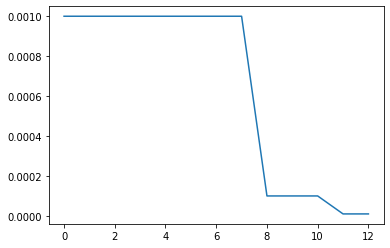

In [ ]:
def visualize_scheduler(optimizer, scheduler, epochs):
    lrs = []
    for _ in range(epochs):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()

    plt.plot(lrs)
    plt.show()

visualize_scheduler(optimizer,scheduler, 13)

# Training
- The hardware performance was not good, so only proceeded with 1 epoch.

In [ ]:
torch.autograd.set_detect_anomaly(True)
for epoch in range(1, epochs + 1):
    model.train()
    print(f'Epoch[{epoch}/{epochs}]')
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss, cls_loss, box_loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (idx + 1) % 100 == 0:
            print(f'Current Step: {idx + 1}, Cls_Loss: {cls_loss},  Box_Loss: {box_loss}, Total_Loss: {loss}')
    # scheduler.step()

Epoch[1/1]
Current Step: 100, Cls_Loss: 0.0008263392955996096,  Box_Loss: 136.2330871920293, Total_Loss: 136.2339135313249
Current Step: 200, Cls_Loss: 0.0008266742806881666,  Box_Loss: 63.585531056864326, Total_Loss: 63.586357731145014
Current Step: 300, Cls_Loss: 0.0008267693337984383,  Box_Loss: 67.88557038455824, Total_Loss: 67.88639715389203
Current Step: 400, Cls_Loss: 0.0008268138044513762,  Box_Loss: 63.44557998644969, Total_Loss: 63.44640680025414
Current Step: 500, Cls_Loss: 0.0008268735837191343,  Box_Loss: 84.58762631697974, Total_Loss: 84.58845319056346
Current Step: 600, Cls_Loss: 0.0008269690442830324,  Box_Loss: 85.27286115504842, Total_Loss: 85.2736881240927
Current Step: 700, Cls_Loss: 0.0008270359830930829,  Box_Loss: 92.18850804016864, Total_Loss: 92.18933507615174
Current Step: 800, Cls_Loss: 0.0008270818507298827,  Box_Loss: 61.1094292415394, Total_Loss: 61.11025632339013
Current Step: 900, Cls_Loss: 0.0008271855767816305,  Box_Loss: 55.33877064272417, Total_Loss: